In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from pytrends.request import TrendReq
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, RobustScaler
import datetime

### Load Data

In [93]:
train = pd.read_csv("ML Intern Homework/intern_homework_train_dataset.csv")
valid = pd.read_csv("ML Intern Homework/intern_homework_public_test_dataset.csv")

# Add new features

train["increasing"] = train["like_count_6h"] - train["like_count_1h"]
valid["increasing"] = valid["like_count_6h"] - valid["like_count_1h"]

# train["forum_average_like"] = train.groupby("forum_id")["like_count_6h"].transform("mean")


In [94]:

# Log transform
train["like_count_1h"] = np.log1p(train["like_count_1h"])
train["like_count_2h"] = np.log1p(train["like_count_2h"])
train["like_count_3h"] = np.log1p(train["like_count_3h"])
train["like_count_4h"] = np.log1p(train["like_count_4h"])
train["like_count_5h"] = np.log1p(train["like_count_5h"])
train["like_count_6h"] = np.log1p(train["like_count_6h"])
train["like_count_24h"] = np.log1p(train["like_count_24h"])
train["increasing"] = np.log1p(train["increasing"])

# Remove outliers

valid["like_count_4h"] = np.log1p(valid["like_count_4h"])
valid["like_count_5h"] = np.log1p(valid["like_count_5h"])
valid["like_count_6h"] = np.log1p(valid["like_count_6h"])
valid["like_count_24h"] = np.log1p(valid["like_count_24h"])
valid["increasing"] = np.log1p(valid["increasing"])

train_normal = train[train["like_count_24h"] - train["like_count_6h"] <= 3]
train_outlier = train[train["like_count_24h"] - train["like_count_6h"] > 3]
train.drop(
    train[train["like_count_24h"] - train["like_count_6h"] > 3].index, inplace=True
)
# Split data
x_train = train.loc[
    :, ["like_count_4h", "like_count_5h", "like_count_6h", "increasing"]
].to_numpy()

y_train = train["like_count_24h"].to_numpy()

x_train_outlier = train_outlier.loc[
    :, ["like_count_4h", "like_count_5h", "like_count_6h", "increasing"]
].to_numpy()

y_train_outlier = train_outlier["like_count_24h"].to_numpy()

x_train_normal = train_normal.loc[
    :, ["like_count_4h", "like_count_5h", "like_count_6h", "increasing"]
].to_numpy()

y_train_normal = train_normal["like_count_24h"].to_numpy()

valid_normal = valid[(valid["like_count_6h"] - valid["like_count_1h"]) <= 3]
valid_outlier = valid[(valid["like_count_6h"] - valid["like_count_1h"]) > 3]

x_valid = valid.loc[
    :, ["like_count_4h", "like_count_5h", "like_count_6h", "increasing"]
].to_numpy()
y_valid = valid["like_count_24h"].to_numpy()

x_valid_normal = valid_normal.loc[
    :, ["like_count_4h", "like_count_5h", "like_count_6h", "increasing"]
].to_numpy()
y_valid_normal = valid_normal["like_count_24h"].to_numpy()

x_valid_outlier = valid_outlier.loc[
    :, ["like_count_4h", "like_count_5h", "like_count_6h", "increasing"]
].to_numpy()
y_valid_outlier = valid_outlier["like_count_24h"].to_numpy()


print(x_train_normal.shape)
print(x_train_outlier.shape)
print(x_valid_normal.shape)
print(x_valid_outlier.shape)

(49201, 4)
(799, 4)
(9910, 4)
(90, 4)


In [30]:
train["like_count_24h"].quantile(0.6)

2.8903717578961645

### Show Correlation

/var/folders/nc/zmjfff853y33j17lwwdk299w0000gn/T/ipykernel_90391/3591571268.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_normal.corr())


<Axes: >

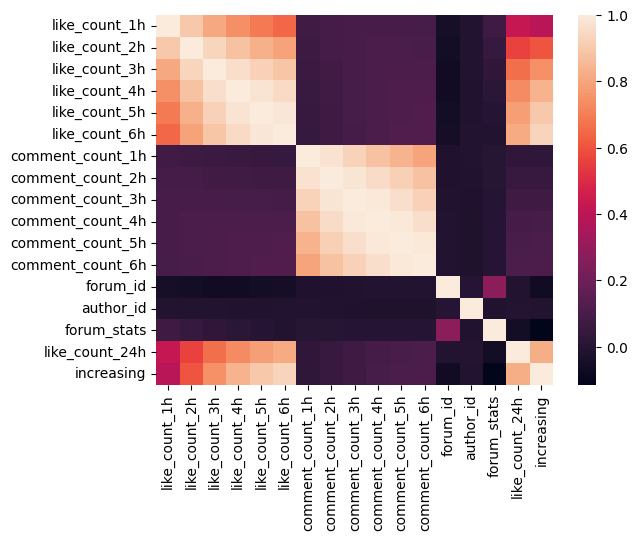

In [97]:
sns.heatmap(train_normal.corr())

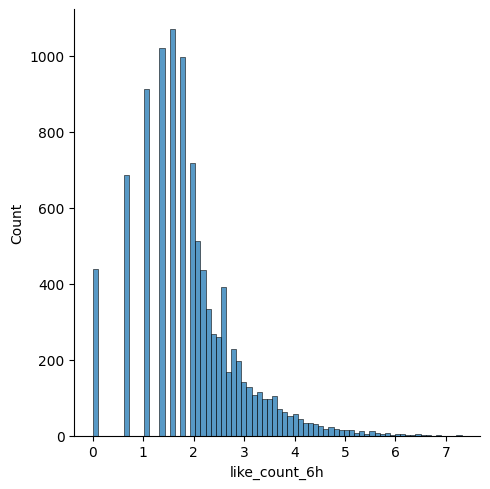

In [37]:
sns.displot(valid["like_count_6h"])

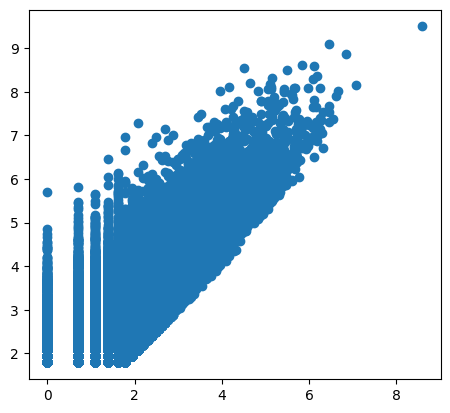

In [101]:
plt.scatter(train["like_count_4h"],train["like_count_24h"])
plt.gca().set_aspect(1)

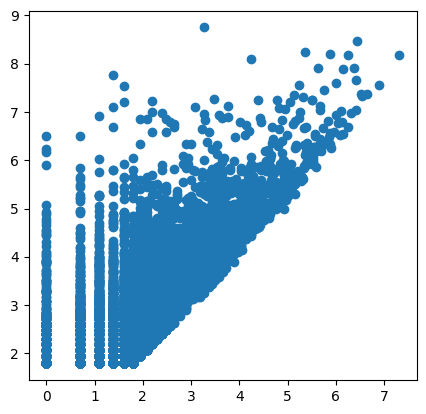

In [62]:
plt.scatter(valid["like_count_6h"], valid["like_count_24h"])
plt.gca().set_aspect(1)


In [74]:
# Skewness and Kurtosis
print("Skewness: %f" % train_outlier['like_count_24h'].skew())
print("Kurtosis: %f" % train_outlier['like_count_24h'].kurt())

Skewness: 0.978185
Kurtosis: 0.876816


### Models

In [95]:
xgb_norm = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
)

xgb_norm.fit(x_train_normal, y_train_normal)
y_pred = xgb_norm.predict(x_valid_normal)
mape = mean_absolute_percentage_error(y_valid_normal, y_pred)

print(f"MAPE: {mape}")

MAPE: 0.1373143915141213


In [88]:
xgboost = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
)

xgboost.fit(x_train, y_train)
y_pred = xgboost.predict(x_valid)
mape = mean_absolute_percentage_error(y_valid, y_pred)

print(f"MAPE: {mape}")

MAPE: 0.1369698437294813


In [5]:
from sklearn.model_selection import GridSearchCV

param = {
    "n_estimators": [500, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 0.9, 1],
}

xgb_norm = XGBRegressor()

grid = GridSearchCV(xgb_norm, param, scoring="neg_mean_absolute_percentage_error", cv=5)
grid.fit(x_train_normal, y_train_normal)


print(grid.best_params_)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}


In [96]:
xgb_outlier = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=1,
    subsample=0.8,  
)
xgb_outlier.fit(x_train_outlier, y_train_outlier)

y_pred = xgb_outlier.predict(x_valid_outlier)
mape = mean_absolute_percentage_error(y_valid_outlier, y_pred)

print(f"MAPE: {mape}")


MAPE: 0.46088654674127966


In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
)
gbr.fit(x_train_normal, y_train_normal)

y_pred = gbr.predict(x_valid_normal)
mape = mean_absolute_percentage_error(y_valid_normal, y_pred)

print(f"MAPE: {mape}")

MAPE: 0.14550165032678045


### Inference

In [9]:
test = pd.read_csv("ML Intern Homework/intern_homework_private_test_dataset.csv")

test["increasing"] = test["like_count_6h"] - test["like_count_1h"]

test["like_count_4h"] = np.log1p(test["like_count_4h"])
test["like_count_5h"] = np.log1p(test["like_count_5h"])
test["like_count_6h"] = np.log1p(test["like_count_6h"])
test["increasing"] = np.log1p(test["increasing"])

x_test = test.loc[:, ["like_count_4h", "like_count_5h", "like_count_6h", "increasing"]].to_numpy()


In [ ]:
like_count_24h = xgboost.predict(x_test)

like_count_24h = np.expm1(like_count_24h)

df = pd.DataFrame({"like_count_24h": like_count_24h})
df.to_csv("results.csv", index=False)